In [1]:
import os
import pandas as pd
import psycopg2
import datetime

import psycopg2.extras

from sqlalchemy import create_engine

from datetime import datetime, timedelta

import matplotlib.pyplot as plt

import numpy as np

In [2]:
## Reading DB credentials

dbname = os.environ['DBNAME']
dbport = os.environ['DBPORT']
dbhost = os.environ['DBHOST']
dbuser = os.environ['DBUSER']
dbpass = os.environ['DBPASS']

In [3]:
## Getting covariables from Epi-PUMA DB

connection = psycopg2.connect(
    host=dbhost,
    port=dbport,
    database=dbname,
    user=dbuser,
    password=dbpass)

cursr = connection.cursor(cursor_factory = psycopg2.extras.RealDictCursor)

cursr.execute("SELECT id, clasificacion_final FROM covariable")
results = cursr.fetchall()

for covariable in results:
    print(covariable)
    
cursr.close()
connection.close()

RealDictRow([('id', 1), ('clasificacion_final', 'NEGATIVO A SARS-COV-2 POR LABORATORIO')])
RealDictRow([('id', 2), ('clasificacion_final', 'CASO DE COVID-19 CONFIRMADO POR ASOCIACIÓN CLÍNICA EPIDEMIOLÓGICA')])
RealDictRow([('id', 3), ('clasificacion_final', 'CASO DE SARS-COV-2  CONFIRMADO POR LABORATORIO')])
RealDictRow([('id', 4), ('clasificacion_final', 'NO REALIZADO POR LABORATORIO')])
RealDictRow([('id', 5), ('clasificacion_final', 'CASO DE COVID-19 CONFIRMADO POR COMITÉ DE  DICTAMINACIÓN')])
RealDictRow([('id', 6), ('clasificacion_final', 'INVÁLIDO POR LABORATORIO')])
RealDictRow([('id', 7), ('clasificacion_final', 'CASO SOSPECHOSO')])


In [4]:
## Getting data from Epi-PUMA DB

infected = [3] # covariable ID's 

sql = "SELECT date_occurrence, fecha_def, covariable_id, gridid_mun, count(*) as occs \
        FROM occurrence where covariable_id in ({0}) GROUP BY \
        date_occurrence, fecha_def, covariable_id, gridid_mun"\
        .format(','.join([str(strid) for strid in infected]))

engine = create_engine('postgresql://{0}:{1}@{2}:{3}/{4}'.format(
    dbuser,
    dbpass,
    dbhost,
    dbport,
    dbname
))

dfdb = pd.read_sql(sql, engine)
dfdb.head()

,date_occurrence,fecha_def,covariable_id,gridid_mun,occs
0,2022-01-26,9999-99-99,3,15080,10
1,2020-06-20,9999-99-99,3,11018,4
2,2020-07-07,9999-99-99,3,31050,105
3,2020-06-12,9999-99-99,3,07078,6
4,2022-07-16,9999-99-99,3,11044,23


In [26]:
# Top 10 municipalities by number of cases

df_top = dfdb[dfdb['date_occurrence'] != '9999-99-99'][['gridid_mun', 'occs']]\
    .groupby(by=['gridid_mun']).sum().sort_values('occs', ascending=False).head(246)

In [6]:
def process_data(code):
    """
        Description: extract cases and deaths of given municipality
    """
    df_infected = dfdb[dfdb['gridid_mun'] == code][['date_occurrence','occs']].sort_values('date_occurrence')
    df_infected = df_infected.groupby(by='date_occurrence').sum()
    df_infected = df_infected.reset_index()
    df_infected = df_infected.rename(columns={'occs':  'cases'})

    df_deaths = dfdb[(dfdb['gridid_mun'] == code) & (dfdb['fecha_def'] != '9999-99-99')][['fecha_def','occs']]\
        .sort_values('fecha_def')
    df_deaths['fecha_def'] = pd.to_datetime(df_deaths['fecha_def'])
    df_deaths = df_deaths.groupby(by='fecha_def').sum()
    df_deaths = df_deaths.reset_index()
    df_deaths = df_deaths.rename(columns={'occs':  'deaths'})
    
    df = df_infected.merge(df_deaths, how='left', left_on='date_occurrence', right_on='fecha_def')\
        .sort_values('date_occurrence')
    df = df.drop(columns=['fecha_def'])
    df['deaths'] = df['deaths'].fillna(0)
    
    return df

In [7]:
def calculate_best_corr(df):
    """
        Description: plot the correlation between deaths and moved
        cases series and plot
    """
    original_deaths = df.deaths.to_numpy()
    moved_cases = df.cases.tolist()
    days_list = []
    corrs = []

    for days in range(1, 800):
        moved_cases = [0] + moved_cases[:-1]
        corr = np.corrcoef(moved_cases, original_deaths)[0][1]
        days_list.append(days)
        corrs.append(corr)
    
    ymax = max(corrs)
    xpos = corrs.index(ymax)
    xmax = days_list[xpos]
    
    plt.plot(days_list, corrs, color='orange')
    plt.xlabel('Days')
    plt.ylabel('Correlation')
    plt.annotate('({0}, {1})'.format(xmax, ymax), xy=(xmax, ymax), xytext=(xmax, ymax))

In [40]:
def calculate_best_corr_without_plot(df):
    """
        Description: plot the correlation between deaths and moved
        cases series
    """
    original_deaths = df.deaths.to_numpy()
    moved_cases = df.cases.tolist()
    days_list = []
    corrs = []

    for days in range(1, 150):
        moved_cases = [0] + moved_cases[:-1]
        corr = np.corrcoef(moved_cases, original_deaths)[0][1]
        days_list.append(days)
        corrs.append(corr)
    
    ymax = max(corrs)
    xpos = corrs.index(ymax)
    xmax = days_list[xpos]
    return (xmax, ymax)

In [8]:
code = '09007'
df = process_data(code)
df = df[df['date_occurrence'] >= '2020-03-01']
df.head()

,date_occurrence,cases,deaths
1,2020-03-03,1,0.0
2,2020-03-11,1,0.0
3,2020-03-14,2,0.0
4,2020-03-15,2,0.0
5,2020-03-16,2,0.0


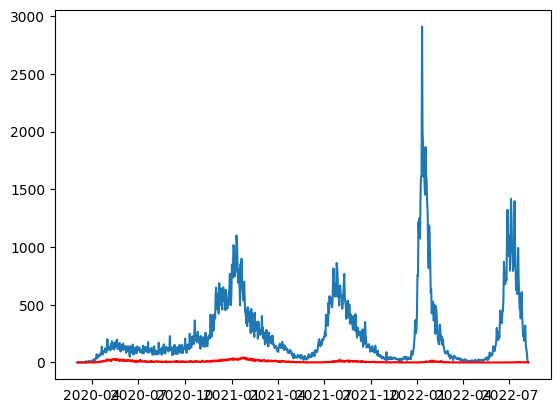

In [9]:
plt.plot(df['date_occurrence'], df['cases'])
plt.plot(df['date_occurrence'], df['deaths'], color='red')

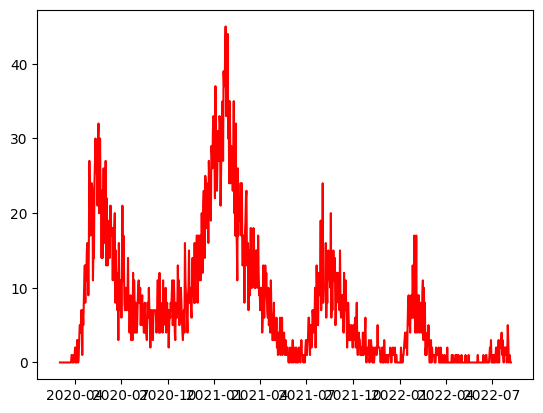

In [10]:
plt.plot(df['date_occurrence'], df['deaths'], color='red')

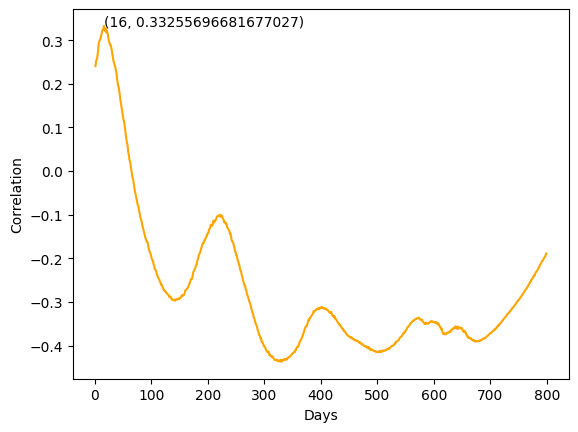

In [11]:
calculate_best_corr(df)

In [12]:
code = '27004'
df = process_data(code)
df = df[df['date_occurrence'] >= '2020-03-01']
df.head()

,date_occurrence,cases,deaths
0,2020-03-09,2,0.0
1,2020-03-10,2,0.0
2,2020-03-13,2,0.0
3,2020-03-15,1,0.0
4,2020-03-16,3,0.0


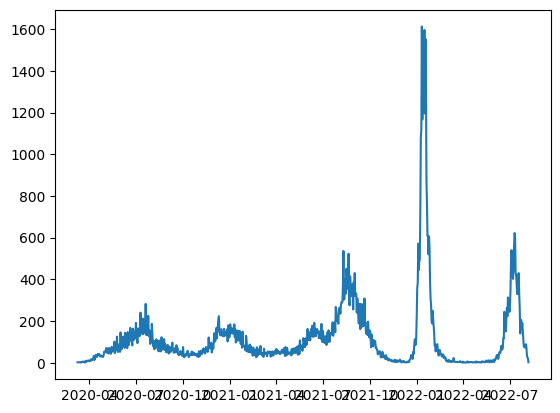

In [13]:
plt.plot(df['date_occurrence'], df['cases'])

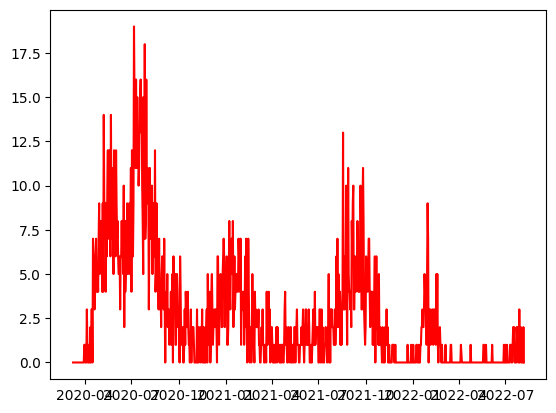

In [14]:
plt.plot(df['date_occurrence'], df['deaths'], color='red')

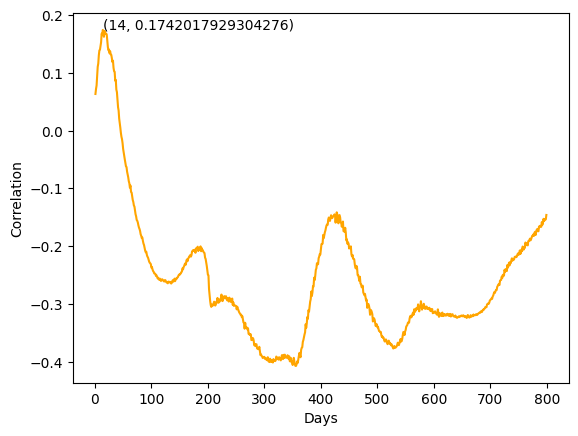

In [15]:
calculate_best_corr(df)

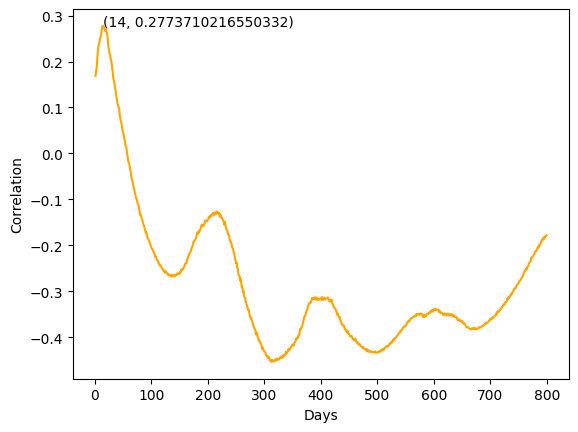

In [16]:
code = '09005'
df = process_data(code)
df = df[df['date_occurrence'] >= '2020-03-01']
calculate_best_corr(df)

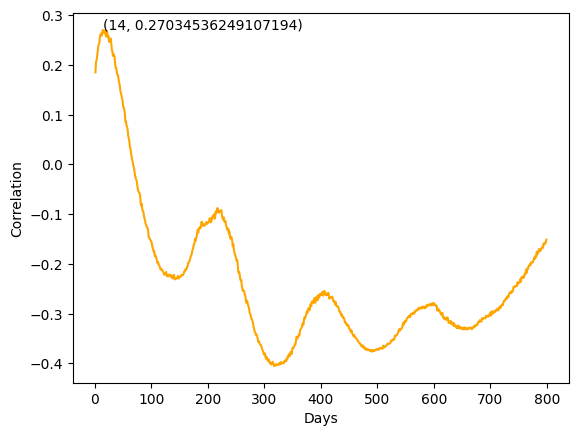

In [17]:
code = '09010'
df = process_data(code)
df = df[df['date_occurrence'] >= '2020-03-01']
calculate_best_corr(df)

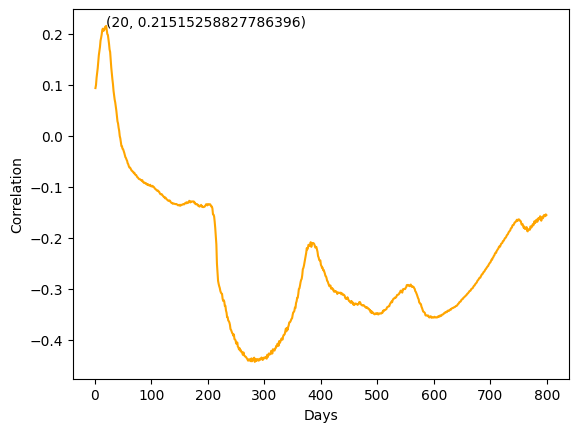

In [18]:
code = '24028'
df = process_data(code)
df = df[df['date_occurrence'] >= '2020-03-01']
calculate_best_corr(df)

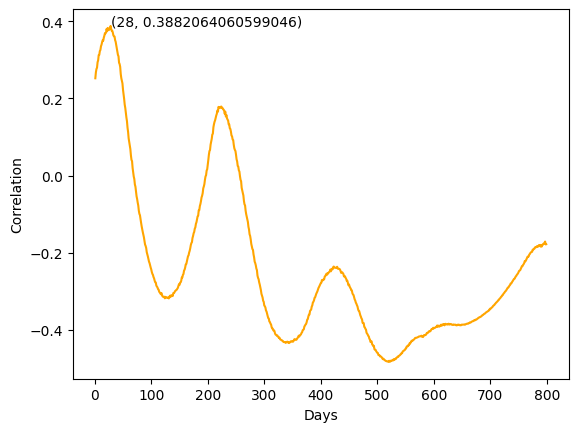

In [19]:
code = '21114'
df = process_data(code)
df = df[df['date_occurrence'] >= '2020-03-01']
calculate_best_corr(df)

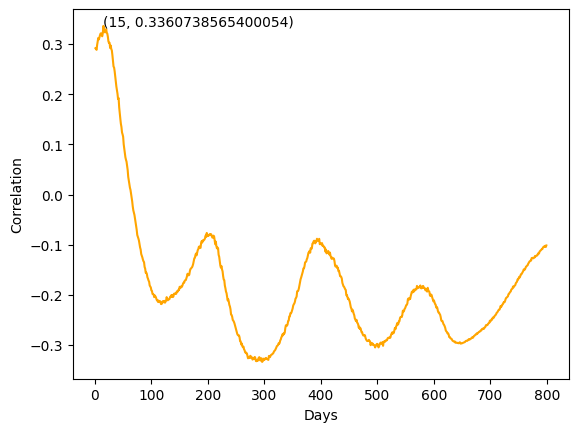

In [20]:
code = '11020'
df = process_data(code)
df = df[df['date_occurrence'] >= '2020-03-01']
calculate_best_corr(df)

In [41]:
max_correlations = []
max_days = []

for index, row in df_top.iterrows():
    #print(index)
    df = process_data(index)
    df = df[df['date_occurrence'] >= '2020-03-01']
    xmax, ymax= calculate_best_corr_without_plot(df)
    max_correlations.append(ymax)
    max_days.append(xmax)

In [49]:
max_correlations = pd.Series(max_correlations)
max_correlations.describe()

count    246.000000
mean       0.248189
std        0.113113
min       -0.004212
25%        0.174754
50%        0.236162
75%        0.309535
max        0.632358
dtype: float64

In [51]:
max_days = pd.Series(max_days)
max_days.describe()

count    246.000000
mean      18.081301
std        6.205453
min        1.000000
25%       14.000000
50%       18.000000
75%       21.000000
max       47.000000
dtype: float64

In [45]:
df_corrs = pd.DataFrame({'days': max_days, 'correlations': max_correlations})
df_corrs.head()

,days,correlations
0,16,0.332557
1,14,0.277371
2,14,0.270345
3,20,0.215153
4,28,0.388206


In [46]:
df_corrs.to_csv('./correlations.csv', index=False)

In [53]:
df_top.head(10)

,occs
gridid_mun,
09007,226740
09005,199913
09010,139004
24028,132920
21114,125801
11020,124922
09012,120701
22014,112236
19039,106424
